# Optimizing Acoustic Simulations

In [1]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jax import numpy as jnp
import jax

The equation we want to simulate is:

$$
\left(\nabla^2 + \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfeld radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{i\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\Big| |x_j| - \Delta_{PML}\Big|^\alpha}{L/2-\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}
$$

## Domain

First, we define the domain where the PDE is solved. In the current version of the software, domains are always represented as scalings of the unit hypercube centered at the origin. Furthermore, an intrinsic discretization must be provided, which is used only by grid-based methods such as Finite Differences or Fourier spectral methods.

Let's define a domain implicitly using a grid of size $256 \times 256$ with $dx=1$:

In [2]:
domain = Domain(N=(256, 256), dx=(1., 1.))

## A First Operator

First, note that the $\sigma$ function has a direct dependence on the coordinate value. Therefore, our first step is to define a `Coordinate` field whose value equals $\mathbf{x}$:

In [3]:
from jaxdf.discretization import Continuous

x = Continuous(None, domain, lambda p, x: x)

Text(0.5, 1.0, '$y$-component of the field x')

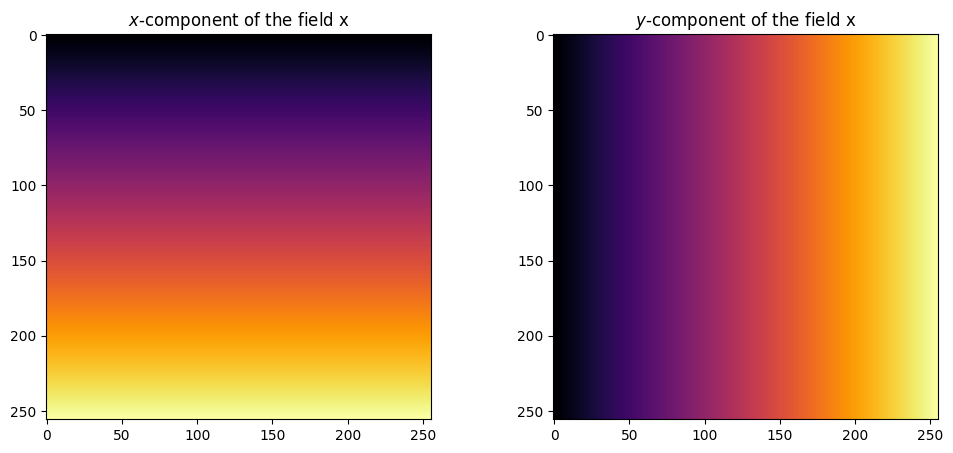

In [5]:
grid = x.on_grid

# Plot the field
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(grid[...,0], cmap="inferno")
ax[0].set_title("$x$-component of the field x")

ax[1].imshow(grid[...,1], cmap="inferno")
ax[1].set_title("$y$-component of the field x")

To construct $\sigma$, let's start with its JAX-numpy implementation:

In [6]:
def sigma(x):
    alpha = 2.
    sigma_star = 1.
    delta_pml = 110.
    L_half = 128.
    
    abs_x = jnp.abs(x)
    in_pml_amplitude = (jnp.abs(abs_x-delta_pml)/(L_half - delta_pml))**alpha
    return jnp.where(abs_x > delta_pml, sigma_star*in_pml_amplitude, 0.)

We can apply this function to the field $x$ using the `compose` operator:

In [7]:
from jaxdf.operators import compose

y = compose(x)(sigma)
print('y: ', y)

y:  Field Continuous


Text(0.5, 1.0, '$y$-component of the field $\\sigma(x)$')

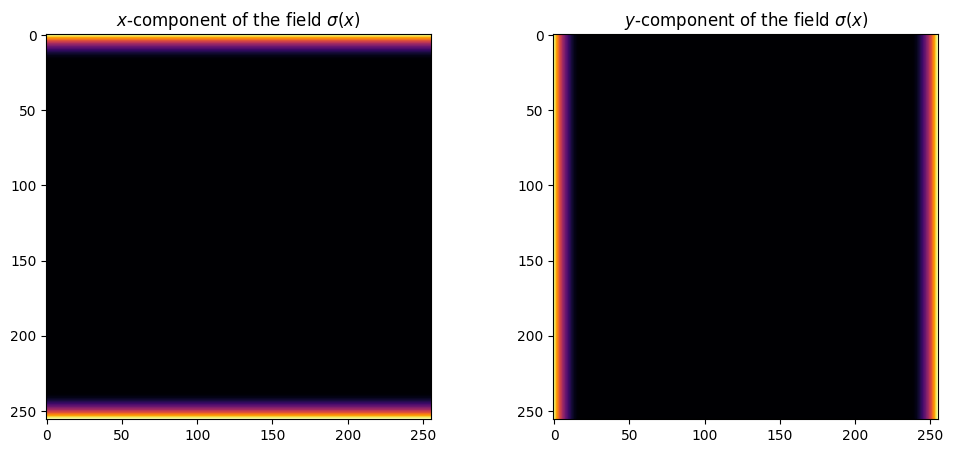

In [8]:
grid = y.on_grid

# Plot the field
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(grid[...,0], cmap="inferno")
ax[0].set_title("$x$-component of the field $\sigma(x)$")

ax[1].imshow(grid[...,1], cmap="inferno")
ax[1].set_title("$y$-component of the field $\sigma(x)$")

## PML Function 

We can now build on this operator to construct more complex ones. In general, we can transform any composition of operators described in a function using the `operator` decorator.

In [9]:
def gamma(x, omega=1.):
    y = compose(x)(sigma)
    return 1./(1. + 1j*y/omega)

pml = gamma(x)

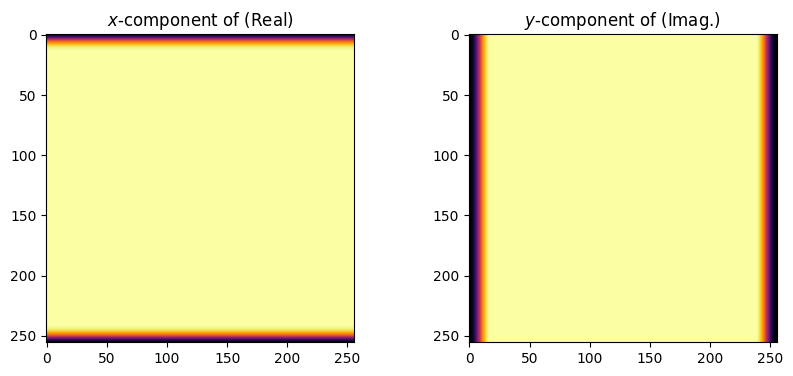

In [10]:
pml_on_grid = pml.on_grid

# Plot the field
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(pml_on_grid[...,0].real, cmap="inferno")
ax[0].set_title("$x$-component of (Real)")
ax[1].imshow(pml_on_grid[...,1].imag, cmap="inferno")
ax[1].set_title("$y$-component of (Imag.)")
plt.show()

## Modified Laplacian Operator

The next step is to define the Laplacian operator $\nabla^2$ using the modified derivatives:

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

That is, we need to define a function over an input field $u$ that evaluates:

$$
\sum_{j=\{x,y\}} \frac{\partial_{x_j}}{\gamma_j} \left( \frac{\partial_{x_j}}{\gamma_j} u \right)
$$

In [13]:
from jaxdf.operators import gradient, diag_jacobian, sum_over_dims

def mod_laplacian(u, pml):
    # No nyquist correction, see https://math.mit.edu/~stevenj/fft-deriv.pdf
    grad_u = gradient(u, correct_nyquist=False)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = diag_jacobian(mod_grad_u, correct_nyquist=False)*pml
    return sum_over_dims(mod_diag_jacobian)

In [14]:
from jaxdf.discretization import FourierSeries

# Defining numerical parameters
params = jnp.zeros((256,256,1)) + 0j
src_params = params.at[128,64].set(1.0)

c_fourier_params = params + 1.  
c_fourier_params = c_fourier_params.at[20:40,20:100].set(2.)
c_fourier_params = c_fourier_params.at[20:200,150:200].set(1.5)

# Defining fields
u = FourierSeries(params, domain)
pml = FourierSeries(pml_on_grid, domain)
c =  FourierSeries(c_fourier_params, domain)
src = FourierSeries(src_params, domain)

## Helmholtz operator

In [15]:
@jax.jit
def helmholtz(u, c, pml, omega=1.):
    # Get the modified laplacian
    L = mod_laplacian(u, pml)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u    
    return L + k

In [16]:
# Wrap around a function to work with GMRES
def helm_func(u):
    return helmholtz(u, c, pml)

In [17]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(helm_func, src, maxiter=1000)

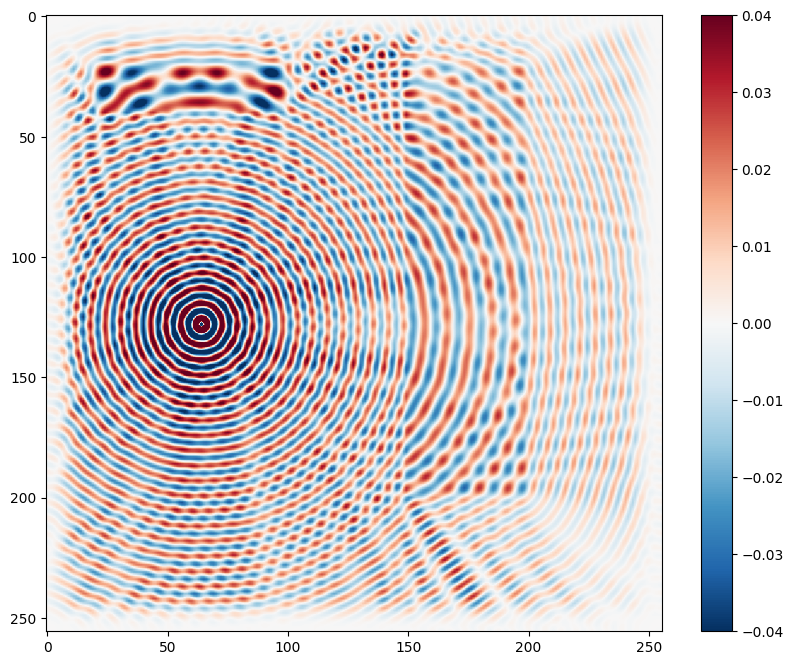

In [20]:
sol_on_grid = sol.on_grid

plt.figure(figsize=(10,8))
plt.imshow(jnp.real(sol_on_grid), cmap="RdBu_r", vmin=-.04, vmax=.04)
plt.colorbar()

## Optimizing the Speed of Sound of a Lens

The following code reproduces the example from the NeurIPS paper. It finds a lens to focus an acoustic source on a target using gradient descent.

In [26]:
from jaxdf.operators import laplacian, compose

@jax.jit
def total_variation(u):
    nabla_u = laplacian(u)
    absval = compose(nabla_u)(jnp.abs)
    return jnp.mean(absval.on_grid)

In [27]:
from jax import random
seed = random.PRNGKey(32)

# Those are the parameters we want to optimize
lens_params = random.uniform(seed, (168,40))-4

def get_sos(T):
    lens = jnp.zeros(domain.N)
    lens = lens.at[44:212,108:148].set(jax.nn.sigmoid(T)) + 1
    return FourierSeries(jnp.expand_dims(lens, -1), domain)

def find_field(c, x0):
    def helm_func(u):
        return helmholtz(u, c, pml)
    sol, _ = gmres(helm_func, src, x0=x0, maxiter=1000, tol=1e-3, restart=10)
    return sol

def loss(p, guess):
    sos = get_sos(p)
    tv_term = total_variation(sos)
    field = find_field(sos, x0=guess)
    target_val = field.on_grid[70,210,0]
    return (-jnp.abs(target_val)) + tv_term, field

In [28]:
from jax.example_libraries import optimizers
from jax import jit
from tqdm import tqdm

losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(lens_params)

@jit
def update(opt_state, field):
    loss_and_field, gradient = jax.value_and_grad(loss, has_aux=True)(get_params(opt_state), field)
    return loss_and_field[0], loss_and_field[1], update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
field = -src
for k in pbar:
    lossval, field, opt_state = update(opt_state, field)
    # For logging
    pbar.set_description("Ampl: {:01.4f}".format(-lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Ampl: 0.1289: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


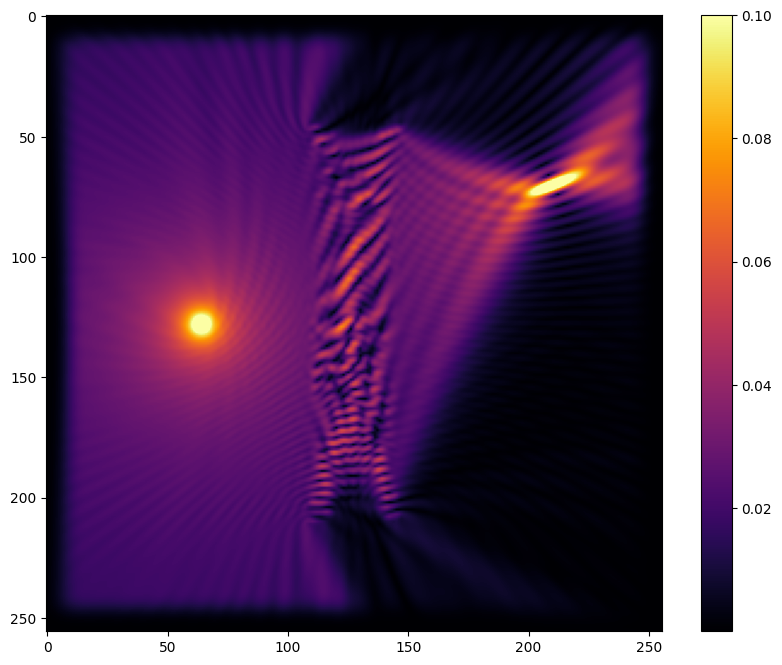

In [30]:
optimal_field = field.on_grid
plt.figure(figsize=(10,8))
plt.imshow(jnp.abs(optimal_field), cmap="inferno", vmax=0.1)
plt.colorbar()

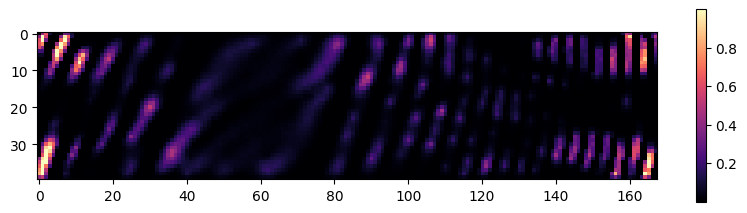

In [37]:
plt.figure(figsize=(10,2.5))
plt.imshow(jax.nn.sigmoid(get_params(opt_state)).T, cmap="magma")
plt.colorbar()

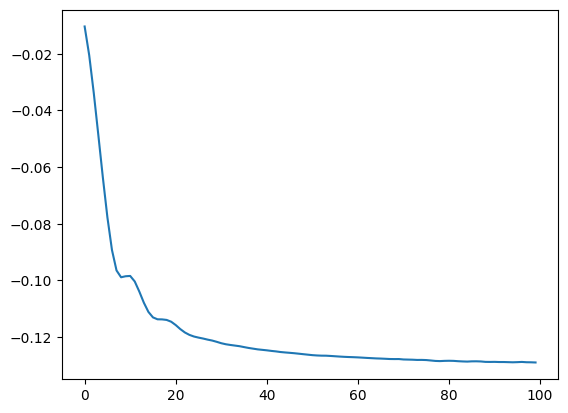

In [38]:
plt.plot(losshistory)

In [39]:
import matplotlib

(-0.5, 39.5, 167.5, -0.5)

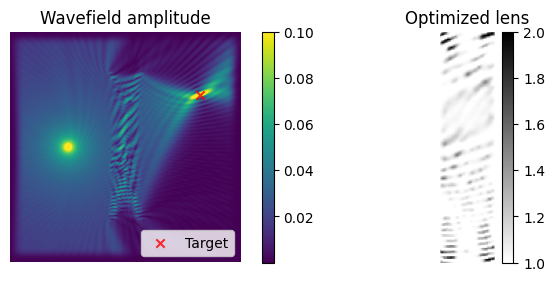

In [42]:
fig, ax = plt.subplots(1,2,figsize=(8,3), gridspec_kw={'width_ratios': [3, 1]})

im1 = ax[0].imshow(jnp.abs(optimal_field), cmap="viridis", vmax=.1)
ax[0].axis("off")
ax[0].scatter(210,70, marker='x', color="red", label="Target", alpha=0.8)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title("Wavefield amplitude")
ax[0].legend(loc="lower right")

sos_opt = get_sos(get_params(opt_state)).on_grid
im2 = ax[1].imshow(sos_opt[44:212,108:148], cmap="binary", vmin=1, vmax=2)
plt.colorbar(im2, ax=ax[1])
ax[1].set_title("Optimized lens")
ax[1].axis("off")

#plt.savefig('img/optimized_lens.pgf')